In [35]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


DATA UNDERSTANDING

Historical data

In [36]:
# ดึงข้อมูลหุ้น AOT
stock_symbol = "AOT.BK"  # สำหรับตลาดหลักทรัพย์ไทย (SET)
df = yf.download(stock_symbol, start="2023-01-01", end="2023-12-31")
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AOT.BK,AOT.BK,AOT.BK,AOT.BK,AOT.BK
Date,,,,,
2023-01-03,73.600090,74.336091,73.600090,73.845424,21950400
2023-01-04,73.109421,73.845422,73.109421,73.845422,17672700
2023-01-05,73.600090,74.090757,72.618755,72.864089,35034500
2023-01-06,74.090759,74.336093,73.845426,74.090759,22225400
2023-01-09,73.845421,74.581422,73.600087,74.581422,22078800


In [15]:
excel_filename = "AOT_Stock_2023.xlsx"
df.to_excel(excel_filename)

In [17]:
df1=pd.read_excel("AOT_Stock_2023.xlsx")
df1.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AOT.BK,AOT.BK,AOT.BK,AOT.BK,AOT.BK
1,Date,NaN,NaN,NaN,NaN,NaN
2,2023-01-03 00:00:00,73.60009,74.336091,73.60009,73.845424,21950400
3,2023-01-04 00:00:00,73.109421,73.845422,73.109421,73.845422,17672700
4,2023-01-05 00:00:00,73.60009,74.090757,72.618755,72.864089,35034500


In [18]:
df1 = df1.drop(df1.index[[0, 1]])
df1.head()

,Price,Close,High,Low,Open,Volume
2,2023-01-03 00:00:00,73.60009,74.336091,73.60009,73.845424,21950400
3,2023-01-04 00:00:00,73.109421,73.845422,73.109421,73.845422,17672700
4,2023-01-05 00:00:00,73.60009,74.090757,72.618755,72.864089,35034500
5,2023-01-06 00:00:00,74.090759,74.336093,73.845426,74.090759,22225400
6,2023-01-09 00:00:00,73.845421,74.581422,73.600087,74.581422,22078800


In [19]:
# เช็คข้อมูลที่หายไป
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Price   Ticker
Close   AOT.BK    0
High    AOT.BK    0
Low     AOT.BK    0
Open    AOT.BK    0
Volume  AOT.BK    0
dtype: int64


In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 2 to 244
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   243 non-null    object
 1   Close   243 non-null    object
 2   High    243 non-null    object
 3   Low     243 non-null    object
 4   Open    243 non-null    object
 5   Volume  243 non-null    object
dtypes: object(6)
memory usage: 11.5+ KB


In [21]:
df1.describe()

,Price,Close,High,Low,Open,Volume
count,243,243.000000,243.000000,243.000000,243.000000,243
unique,243,54.000000,140.000000,143.000000,165.000000,243
top,2023-01-03 00:00:00,70.410759,70.656093,70.165425,70.656093,21950400
freq,1,21.000000,8.000000,7.000000,7.000000,1


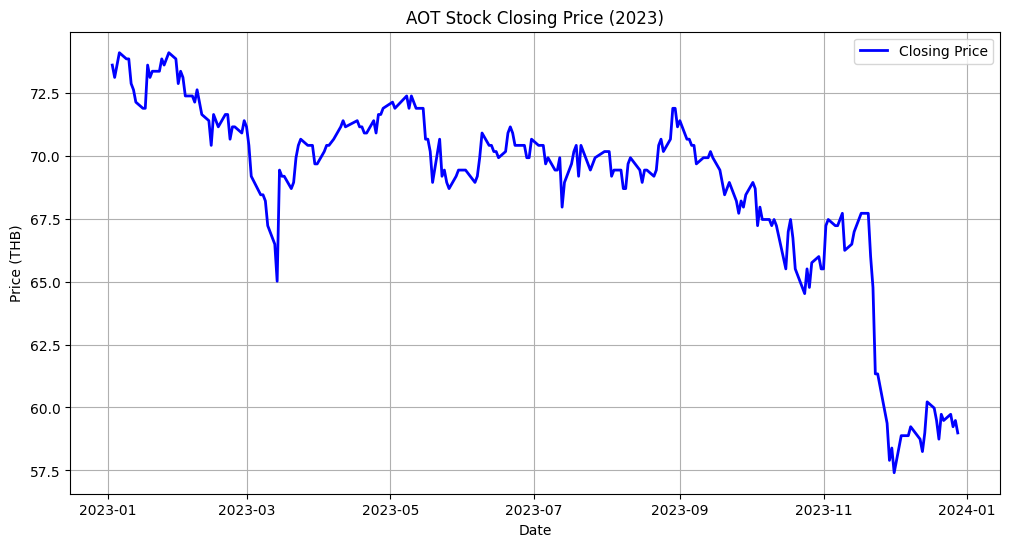

In [22]:
# สร้างกราฟราคาปิดของหุ้น AOT
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Closing Price", linewidth=2, color='blue')

plt.title("AOT Stock Closing Price (2023)")
plt.xlabel("Date")
plt.ylabel("Price (THB)")
plt.legend()
plt.grid()

# แสดงกราฟ
plt.show()


In [ ]:


data = df[["Close"]].values

# สเกลข้อมูลให้อยู่ในช่วง 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# ฟังก์ชันสร้างชุดข้อมูลแบบ Time Series
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# ตั้งค่าช่วงเวลา 60 วันย้อนหลังเพื่อพยากรณ์วันถัดไป
time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# แบ่ง Train-Test (80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# แปลงให้เป็นรูปแบบที่เหมาะสมกับ LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# สร้างโมเดล LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# คอมไพล์โมเดล
model.compile(optimizer="adam", loss="mean_squared_error")

# เทรนโมเดล
model.fit(X_train, Y_train, batch_size=16, epochs=50, verbose=1)

# ทำการพยากรณ์ปี 2024
future_days = 365  # จำนวนวันที่ต้องการทำนาย
future_predictions = []

# ใช้ข้อมูล 60 วันสุดท้ายเป็นจุดเริ่มต้น
last_60_days = scaled_data[-time_step:].reshape(1, time_step, 1)

for _ in range(future_days):
    pred = model.predict(last_60_days, verbose=0)
    pred = pred.reshape(1, 1, 1)  # แปลงให้มีขนาด 3 มิติ
    future_predictions.append(pred[0, 0])
    last_60_days = np.append(last_60_days[:, 1:, :], pred, axis=1)

# แปลงค่ากลับเป็นราคาหุ้นจริง
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# แปลง last_date ให้เป็น datetime
last_date = pd.to_datetime(df.index[-1])

# สร้างช่วงวันที่สำหรับปี 2024
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')


Epoch 1/50
10/10 [==============================] - 9s 54ms/step - loss: 0.1206
Epoch 2/50
10/10 [==============================] - 1s 58ms/step - loss: 0.0125
Epoch 3/50
10/10 [==============================] - 1s 51ms/step - loss: 0.0067
Epoch 4/50
10/10 [==============================] - 0s 45ms/step - loss: 0.0050
Epoch 5/50
10/10 [==============================] - 0s 48ms/step - loss: 0.0049
Epoch 6/50
10/10 [==============================] - 1s 61ms/step - loss: 0.0045
Epoch 7/50
10/10 [==============================] - 1s 72ms/step - loss: 0.0041
Epoch 8/50
10/10 [==============================] - 0s 49ms/step - loss: 0.0039
Epoch 9/50
10/10 [==============================] - 1s 57ms/step - loss: 0.0040
Epoch 10/50
10/10 [==============================] - 1s 57ms/step - loss: 0.0036
Epoch 11/50
10/10 [==============================] - 1s 51ms/step - loss: 0.0038
Epoch 12/50
10/10 [==============================] - 1s 52ms/step - loss: 0.0035
Epoch 13/50
10/10 [==================

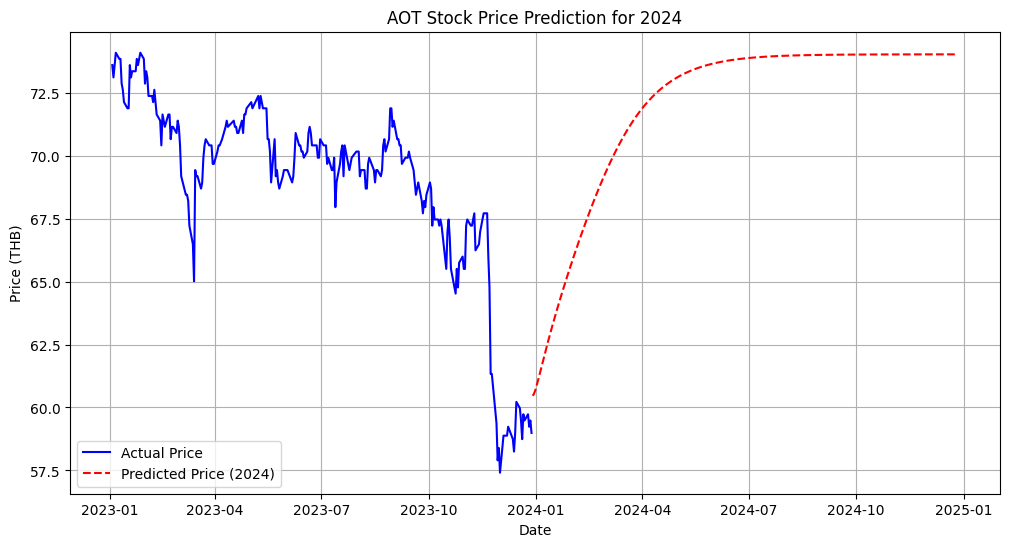

In [24]:
# ตรวจสอบและแปลง df.index และ future_dates เป็น datetime
df.index = pd.to_datetime(df.index, errors="coerce")
future_dates = pd.to_datetime(future_dates, errors="coerce")

# วาดกราฟทำนายราคาหุ้นปี 2024
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Actual Price", color="blue")
plt.plot(future_dates, future_predictions, label="Predicted Price (2024)", color="red", linestyle="dashed")
plt.title("AOT Stock Price Prediction for 2024")
plt.xlabel("Date")
plt.ylabel("Price (THB)")
plt.legend()
plt.grid()
plt.show()


In [25]:

# สร้าง DataFrame สำหรับผลลัพธ์การพยากรณ์
predicted_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Price": future_predictions.flatten()
})


In [26]:
predicted_df.head(10)

,Date,Predicted Price
0,2023-12-29,60.465385
1,2023-12-30,60.532658
2,2023-12-31,60.652664
3,2024-01-01,60.803375
4,2024-01-02,60.971458
5,2024-01-03,61.148926
6,2024-01-04,61.330982
7,2024-01-05,61.514759
8,2024-01-06,61.698559
9,2024-01-07,61.881363


In [29]:
# ดึงข้อมูลหุ้น AOT
stock_symbol = "AOT.BK"  # สำหรับตลาดหลักทรัพย์ไทย (SET)
df = yf.download(stock_symbol, start="2024-01-01", end="2024-12-31")
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AOT.BK,AOT.BK,AOT.BK,AOT.BK,AOT.BK
Date,,,,,
2024-01-03,61.703629,62.197258,61.210000,61.456814,40506100
2024-01-04,63.184517,63.184517,61.950444,61.950444,37899200
2024-01-05,62.690887,63.431331,62.197258,63.184516,41945900
2024-01-08,62.197258,62.937702,61.950443,62.937702,22082100
2024-01-09,61.950443,62.937701,61.950443,62.690887,13944500


In [ ]:
# Predict on X_test, not future data
Y_pred_test = model.predict(X_test, verbose=0)
# Inverse transform predictions and actual labels
Y_pred_test_original = scaler.inverse_transform(Y_pred_test.reshape(-1, 1))
Y_test_original = scaler.inverse_transform(Y_test.reshape(-1, 1))

mse = mean_squared_error(Y_test_original, Y_pred_test_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_original, Y_pred_test_original)
r2 = r2_score(Y_test_original, Y_pred_test_original)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R² Score: {r2:.4f}')



MSE: 6.2394
RMSE: 2.4979
MAE: 1.7125
R² Score: 0.5750
